In [12]:
%pip install yfinance
%pip install requests
%pip install praw

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import logging
import praw
from datetime import datetime, timedelta

# Data Collection

## 1. Ubisoft (UBI.PA) Stock Price - Yahoo Finance

In [11]:
# Define the Ubisoft ticker on Euronext Paris
ticker_symbol = "UBI.PA"

# Create the Ticker object
ubisoft = yf.Ticker(ticker_symbol)

# Fetch historical price data
# For scalability, the period can be changed to a longer period or a specified timeframe
ubisoft_hist = ubisoft.history(period="1y", interval="1d")

# Save to Parquet
ubisoft_hist.to_parquet("data/ubisoft_stock.parquet")

# Preview the data
ubisoft_hist.info()
print(ubisoft_hist.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 258 entries, 2024-04-04 00:00:00+02:00 to 2025-04-04 00:00:00+02:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          258 non-null    float64
 1   High          258 non-null    float64
 2   Low           258 non-null    float64
 3   Close         258 non-null    float64
 4   Volume        258 non-null    int64  
 5   Dividends     258 non-null    float64
 6   Stock Splits  258 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 16.1 KB
                                Open       High        Low      Close  Volume  \
Date                                                                            
2024-04-04 00:00:00+02:00  19.820000  19.975000  19.520000  19.860001  357334   
2024-04-05 00:00:00+02:00  19.549999  19.815001  19.120001  19.815001  496791   
2024-04-08 00:00:00+02:00  19.840000  20.700001  19.825001  20.700001  863889   
2024

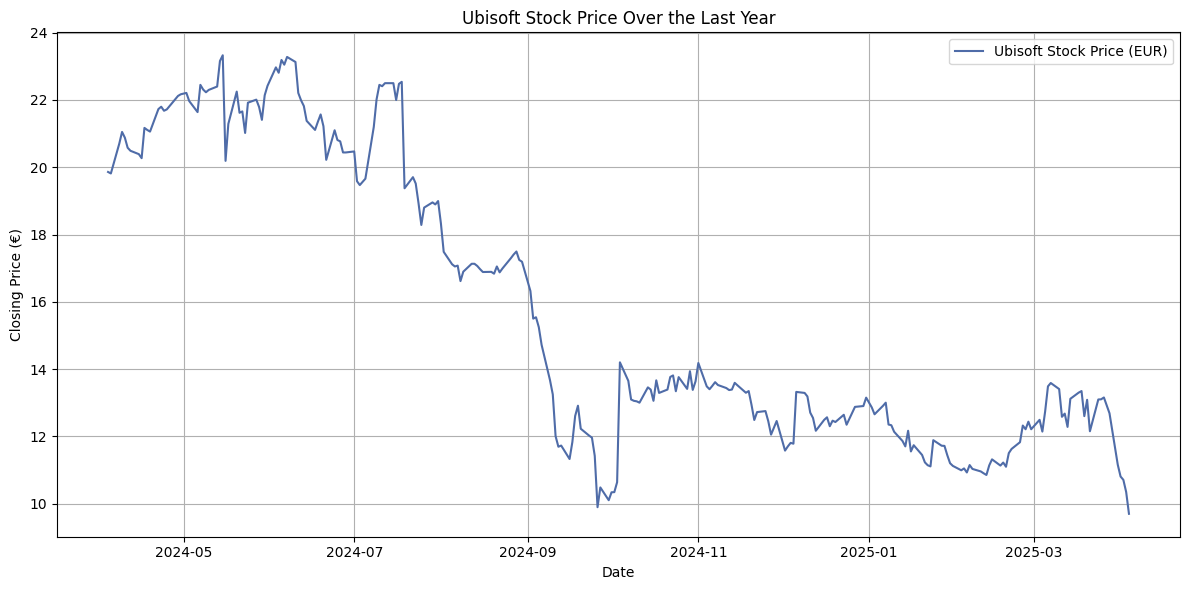

In [8]:
# Load Ubisoft stock data
ubisoft = yf.Ticker("UBI.PA")
hist = ubisoft.history(period="1y", interval="1d")

# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(hist.index, hist["Close"], label="Ubisoft Stock Price (EUR)", color="#4F6CA8")
plt.title("Ubisoft Stock Price Over the Last Year")
plt.xlabel("Date")
plt.ylabel("Closing Price (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Ubisoft Event Timeline

## 3. Product (Video Game) Reviews
### 3.1 Steam Reviews

In [ ]:
# Configure logging for error awareness and debugging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set up SteamDB AppID
appid = "3159330"  # AppID for Assassin's Creed Shadows
base_url = f"https://store.steampowered.com/appreviews/{appid}"  # Base URL for the Steam review API

# Define API parameters
params = {
    "json": 1,
    "filter": "recent",       # Options: 'recent' or 'all'
    "language": "english",    # Language filter for reviews
    "day_range": 365,         # Fetch reviews from the last 365 days
    "review_type": "all",     # Options: 'all', 'positive', 'negative'
    "purchase_type": "all",   # Options: 'all', 'steam', 'non_steam'
    "num_per_page": 100,      # Number of reviews per page
    "cursor": "*"             # Initial cursor value for pagination
}

# Storage for the collected reviews
steam_reviews = []
cursor = "*"  # Start cursor for pagination
previous_count = 0 # Track previous number of reviews

# Loop to fetch all pages of reviews
while cursor:

    # Log and display progress during runtime
    logging.info(f"Page {len(steam_reviews) // params['num_per_page'] + 1} - Total reviews collected: {len(steam_reviews)}")
    params["cursor"] = cursor
    try:
        # Make the API request with a timeout to avoid hanging indefinitely
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP status codes 4xx/5xx
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed: {e}")
        break

    try:
        # Parse the JSON response
        data = response.json()
    except ValueError as e:
        logging.error(f"Error parsing JSON: {e}")
        break

    # Check if 'reviews' key exists in the JSON response
    if "reviews" not in data:
        logging.warning("No reviews found in the response. Exiting pagination loop.")
        break

    # Process each review entry in the current page
    for r in data["reviews"]:
        # Safely access the 'author' details, defaulting to an empty dict if missing
        author = r.get("author", {})

        # Append the structured review data to our list, using .get() for safe access
        steam_reviews.append({
            "review_id": r.get("recommendationid"),
            "language": r.get("language"),
            "review": r.get("review"),
            "voted_up": r.get("voted_up"),
            "votes_helpful": r.get("votes_helpful", 0),  # Default to 0 if missing
            "votes_funny": r.get("votes_funny", 0),        # Default to 0 if missing
            "timestamp_created": r.get("timestamp_created"),
            "steamid": author.get("steamid"),
            "playtime_forever": author.get("playtime_forever", 0)  # Default to 0 if missing
        })

    # Update the cursor for the next page
    cursor = data.get("cursor")  # Fetch the next page cursor, if available

    # If no cursor is found, it means we've reached the last page
    if not cursor:
        logging.info("No more reviews to fetch. Ending pagination.")
        break

    # Sleep to avoid hitting rate limits
    time.sleep(3)

    # Break if review count has stopped growing
    current_count = len(steam_reviews)
    if current_count == previous_count:
        logging.info("No new reviews collected in this iteration. Ending loop.")
        break
    previous_count = current_count  # Update tracker

# Convert the list of review dictionaries into a DataFrame
steam_reviews_df = pd.DataFrame(steam_reviews)

logging.info(f"Collected {len(steam_reviews_df)} reviews.")

INFO: Page 1 - Total reviews collected: 0
INFO: Page 2 - Total reviews collected: 100
INFO: Page 3 - Total reviews collected: 200
INFO: Page 4 - Total reviews collected: 300
INFO: Page 5 - Total reviews collected: 400
INFO: Page 6 - Total reviews collected: 500
INFO: Page 7 - Total reviews collected: 600
INFO: Page 8 - Total reviews collected: 700
INFO: Page 9 - Total reviews collected: 800
INFO: Page 10 - Total reviews collected: 900
INFO: Page 11 - Total reviews collected: 1000
INFO: Page 12 - Total reviews collected: 1100
INFO: Page 13 - Total reviews collected: 1200
INFO: Page 14 - Total reviews collected: 1300
INFO: Page 15 - Total reviews collected: 1400
INFO: Page 16 - Total reviews collected: 1500
INFO: Page 17 - Total reviews collected: 1600
INFO: Page 18 - Total reviews collected: 1700
INFO: Page 19 - Total reviews collected: 1800
INFO: Page 20 - Total reviews collected: 1900
INFO: Page 21 - Total reviews collected: 2000
INFO: Page 22 - Total reviews collected: 2100
INFO: Pag

In [5]:
# Check for duplicated rows
num_duplicates = steam_reviews_df.duplicated().sum()

# Print the number of duplicated rows
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [6]:
# Convert the list of review dictionaries into a DataFrame
steam_reviews_df = pd.DataFrame(steam_reviews)

# Convert collected raw data into readable units
steam_reviews_df["review_date"] = pd.to_datetime(steam_reviews_df["timestamp_created"], unit="s")
steam_reviews_df["playtime_hours"] = (steam_reviews_df["playtime_forever"] / 60).round(2)

# Drop original raw data
steam_reviews_df = steam_reviews_df.drop(columns=["timestamp_created", "playtime_forever"])

In [7]:
# Preview the collected data
steam_reviews_df.info()
steam_reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review_id       5600 non-null   object        
 1   language        5600 non-null   object        
 2   review          5600 non-null   object        
 3   voted_up        5600 non-null   bool          
 4   votes_helpful   5600 non-null   int64         
 5   votes_funny     5600 non-null   int64         
 6   steamid         5600 non-null   object        
 7   review_date     5600 non-null   datetime64[ns]
 8   playtime_hours  5600 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 355.6+ KB


,review_id,language,review,voted_up,votes_helpful,votes_funny,steamid,review_date,playtime_hours
0,191961666,english,So I am leaving this review after finally mana...,False,0,0,76561198821975080,2025-04-04 14:27:06,1.77
1,191961543,english,"I`ve played this game for just over 24-hours, ...",True,0,0,76561198087876283,2025-04-04 14:25:29,25.58
2,191961234,english,Here's something I didn't expect to ever say a...,True,0,0,76561199566919456,2025-04-04 14:20:44,15.20
3,191959532,english,"After playing for around 35 hours, I can confi...",True,0,0,76561198022115523,2025-04-04 13:56:40,34.43
4,191958597,english,I actually love this game. At first I was skep...,True,0,0,76561198800347997,2025-04-04 13:43:01,55.50


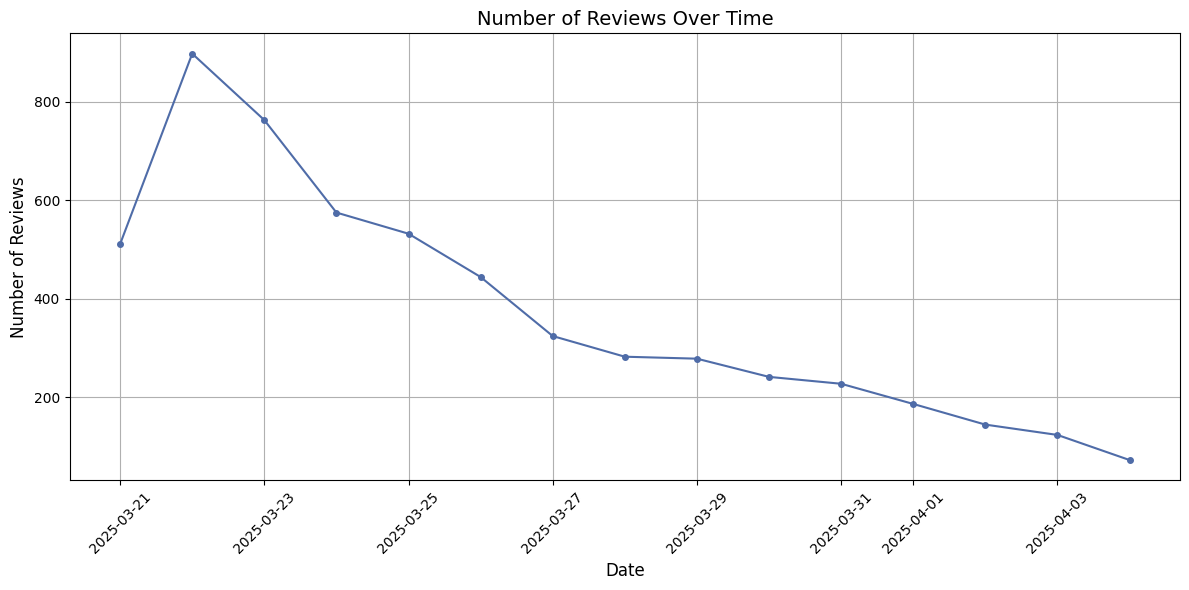

In [25]:
# Group by review date (daily)
reviews_per_day = steam_reviews_df.groupby(steam_reviews_df["review_date"].dt.date).size()

# Plot the number of reviews per day
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_day.index, reviews_per_day.values, marker='o', color='#4F6CA8', linestyle='-', markersize=4)

# Add labels and title
plt.title("Number of Reviews Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [10]:
# Save Steam reviews to Parquet
steam_reviews_df.to_parquet("data/steam_reviews.parquet")

### 3.2 Reddit Game Reviews

In [ ]:
# Load credentials
CLIENT_ID = "FZJOtrIGzYUIVNyuZU5fMQ"
CLIENT_SECRET = "aN0eOROtNbPRecCsxCl0h9Nt3LQT6w"
APP_NAME = "ubisoft_analysis by u/Former_Click6621"

In [55]:
def scrape_reddit(subreddit_name, start_date, max_total_posts, max_days=15):
    """
    Scrape Reddit posts and comments from a subreddit within a specific date range.

    Parameters:
        subreddit_name (str): Target subreddit to scrape.
        start_date (datetime): Starting date for scraping.
        max_total_posts (int): Maximum total number of posts to scrape.
        max_days (int): Time window in days (default = 15).

    Returns:
        reddit_posts_df (pd.DataFrame): DataFrame of scraped posts.
        reddit_comments_df (pd.DataFrame): DataFrame of scraped comments.
    """
    
    # Initialize PRAW
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=APP_NAME
    )

    subreddit = reddit.subreddit(subreddit_name)

    # Time window
    end_date = start_date + timedelta(days=max_days)
    start_ts = start_date.timestamp()
    end_ts = end_date.timestamp()

    posts = []
    comments = []

    print(f"Collecting posts from {start_date.date()} to {end_date.date()}...")

    # Fetch new posts, filter by date
    for post in subreddit.hot(limit=None):
        if len(posts) >= max_total_posts:
            break

        # Filter by timestamp window
        if start_ts <= post.created_utc <= end_ts:
            try:
                post.comments.replace_more(limit=0)
            except Exception as e:
                print(f"Error loading comments for post {post.id}: {e}")
                continue

            posts.append({
                "id": post.id,
                "title": post.title,
                "selftext": post.selftext,
                "created_utc": post.created_utc,
                "created_date": datetime.utcfromtimestamp(post.created_utc),
                "score": post.score,
                "num_comments": post.num_comments,
                "url": post.url
            })

            for comment in post.comments.list():
                comments.append({
                    "post_id": post.id,
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "comment_score": comment.score,
                    "comment_author": str(comment.author),
                    "comment_created_utc": comment.created_utc,
                    "comment_created_date": datetime.utcfromtimestamp(comment.created_utc)
                })

    print(f"Collected {len(posts)} posts and {len(comments)} comments.")

    # Convert to dataframes
    reddit_posts_df = pd.DataFrame(posts)
    reddit_comments_df = pd.DataFrame(comments)

    # Drop unneeded original datetime info
    reddit_posts_df = reddit_posts_df.drop(columns="created_utc")
    reddit_comments_df = reddit_comments_df.drop(columns="comment_created_utc")

    return reddit_posts_df, reddit_comments_df

In [56]:
# Set parameters
start_date = datetime(2025, 3, 20)
max_total_posts = 500
max_days = 15
subreddit_name = "AssassinsCreedShadows"

# Call on function to collect data from Reddit
acshadows_reddit_posts_df, acshadows_reddit_comments_df = scrape_reddit(subreddit_name, start_date, max_total_posts, max_days)

Collected 500 posts and 6024 comments.


In [57]:
acshadows_reddit_posts_df.info()
acshadows_reddit_posts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            500 non-null    object        
 1   title         500 non-null    object        
 2   selftext      500 non-null    object        
 3   created_date  500 non-null    datetime64[ns]
 4   score         500 non-null    int64         
 5   num_comments  500 non-null    int64         
 6   url           500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 27.5+ KB


,id,title,selftext,created_date,score,num_comments,url
0,1jjm9ke,AC Shadows title update 1.0.1 (Hotfix) - Relea...,"Hello Assassins, thank you so much for all the...",2025-03-25 15:37:17,313,286,https://i.redd.it/f3bl7bw6vuqe1.jpeg
1,1jfjvnx,[Megathread] Discuss Main Game Spoilers Here,"Hello everyone,\n\nThis megathread is dedicate...",2025-03-20 08:03:22,7,51,https://www.reddit.com/r/AssassinsCreedShadows...
2,1jqvtwz,I so wish we could build a hot spring in the c...,One thing I loved from Ghost of Tsushima was c...,2025-04-03 22:10:14,512,185,https://i.redd.it/pgsr256i1pse1.jpeg
3,1jqtfht,Selfie time,,2025-04-03 20:33:49,400,6,https://i.redd.it/2zbgofrakose1.jpeg
4,1jqwxf4,I sailed from Obama to Miyazu Bay and it made ...,I MISS MY BOATS.\n\nI miss the skald that play...,2025-04-03 22:58:25,184,85,https://www.reddit.com/gallery/1jqwxf4


In [59]:
acshadows_reddit_comments_df.info()
acshadows_reddit_comments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6024 entries, 0 to 6023
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   post_id               6024 non-null   object        
 1   comment_id            6024 non-null   object        
 2   comment_body          6024 non-null   object        
 3   comment_score         6024 non-null   int64         
 4   comment_author        6024 non-null   object        
 5   comment_created_date  6024 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 282.5+ KB


,post_id,comment_id,comment_body,comment_score,comment_author,comment_created_date
0,1jjm9ke,mjogrpx,Does anyone else wish you could just sit down ...,166,_MostPalone_,2025-03-25 16:37:25
1,1jjm9ke,mjo4lcz,"View in your timezone: \n[Mar 25, 18:00 UTC][...",22,timee_bot,2025-03-25 15:37:33
2,1jjm9ke,mjoy7n7,Hope they fixed were your sheath disappears fo...,23,Ok_Construction2434,2025-03-25 17:49:15
3,1jjm9ke,mjpqkqt,Hopefully it fixes the Tools Master “throw an ...,37,grizzy77,2025-03-25 20:07:30
4,1jjm9ke,mjqy5d9,Weather system is phenomenal,11,s2keddie,2025-03-25 23:48:58


In [58]:
# Save the data to parquet files
acshadows_reddit_posts_df.to_parquet("data/acshadows_reddit_posts.parquet", index=False)
acshadows_reddit_comments_df.to_parquet("data/acshadows_reddit_comments_df.parquet", index=False)

## 4. Load into XXX DB